# 深層学習スクラッチ　畳み込みNネットワーク１

スクラッチで1次元用畳み込みニューラルネットワークを実装した後、学習と検証を行う

In [1]:
#基本ライブラリ
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
#scikit-learnライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

#データセット
#from sklearn.datasets import load_iris

CNNでは画像に対しての2次元畳み込み層が定番だが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装する。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多い。畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されている。

検証には引き続きMNISTデータセットを使用する。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力する。

In [3]:
#MNISTデータセット
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#平滑化
X_train_f = X_train.reshape(-1, 784)
X_test_f = X_test.reshape(-1, 784)

#前処理
X_train_ff = X_train_f.astype(np.float)
X_test_ff = X_test_f.astype(np.float)
X_train_ff /= 255
X_test_ff /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

Xt_train, Xt_val, yt_train, yt_val = train_test_split(X_train_ff, y_train_one_hot, test_size=0.2)
print(Xt_train.shape) # (48000, 784)
print(Xt_val.shape) # (12000, 784)
print(yt_train.shape)
print(yt_val.shape)

Using TensorFlow backend.


(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


## SimpleConv1d

チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成する。基本構造は前のSprintで作成した全結合層のFCクラスと同じになる。なお、重みの初期化に関するクラスは必要に応じて作り変える。Xavierの初期値などを使う点は全結合層と同様。

### 処理の流れを確認

In [4]:
#重み
n_features = 784
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1) #（n行、m列）でガウス分布を作る
print(W1.shape)

#バイアス
n_features = 1
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
B1 = sigma * np.random.randn(n_features, n_nodes1) #（n行、m列）でガウス分布を作る

#XW　＝48,000×400の行列を作る
XW1 = np.dot(Xt_train, W1)

print(XW1.shape)  #(48000, 400)

A1 = XW1+B1

print(A1.shape)

filter1 = np.random.rand(3)
print(filter1)

(784, 400)
(48000, 400)
(48000, 400)
[0.95238779 0.15849382 0.80350779]


In [5]:
FA1 = np.zeros(A1.shape)

for i in range(0, A1.shape[1] - len(filter1) + 1):
    FA1[0][i] = np.sum(A1[0][i: i+len(filter1)]*filter1)+1


In [6]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
a = np.array([0,0])

for i in range(0, len(x) - len(w) + 1):
    a[i] = np.sum(x[i: i+len(w)]*w)+b
print(a)



[35 50]


In [7]:
#実装上の工夫
indexes = np.array([[0,1,2],[1,2,3]])
print(np.dot(x[indexes], w)+b)

[35 50]


### 出力サイズの関数

In [8]:

def N_out(N_in, P, F, S):
    return (N_in + 2*P - F) / S + 1

P = 0
F = len(w)
S = 1

print(N_out(len(x), P, F, S))

2.0


### バックプロパゲーション

In [9]:
y = np.array([45, 70])
da = y - a
print(da)

[10 20]


In [10]:
db = np.sum(da)
print("バイアスの傾き:", db)

バイアスの傾き: 30


In [11]:
dw = np.zeros(3)
for i in range(2):
    dw += (x[i: i+len(w)] * da[i])
print("フィルタの傾き", dw)    

フィルタの傾き [ 50.  80. 110.]


In [12]:
dx = np.zeros(len(x))
for i in range(2):
    dx[i: i+len(w)] += da[i]*w
print("xの傾き:", dx )

xの傾き: [ 30. 110. 170. 140.]


In [23]:
class SimpleConv1d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    
    def __init__(self, initializer, optimizer, pad=0, fsize=0, stride=1):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.pad = pad
        self.fsize = fsize
        self.stride = stride
        self.W =  initializer.W(fsize)
        self.B = 0
  
    
    def forward(self, X, w, b, init=False):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        if init:
            self.X = X
            self.W = w
            self.B = b
            self.LW = np.zeros(len(self.W))
            self.LX = np.zeros(len(X))
            self.A = np.zeros(int(N_out(len(X), self.pad, self.fsize, self.stride)))
        
        for i in range(0, len(X) - len(self.W) + 1):
            self.A[i] = np.sum(X[i: i+len(self.W)] * self.W)+self.B        
        
        return self.A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.LB = np.sum(dA)
        
        for i in range(len(dA)):
            self.LW += (self.X[i: i+len(self.W)] * dA[i])
        
        for i in range(2):
            self.LX[i: i+len(self.W)] += dA[i]*self.W
        
        LX = self.LX
        # 更新
        self = self.optimizer.update(self)
        #FC2 = FC2.optimizer.updata(FC2)
        #FC2 = SGD().update(FC2)
        
        return LX
    
    def N_out(N_in, P, F, S):
        return (N_in + 2*P - F) / S + 1



In [24]:
test = SimpleConv1d(OneInit(), SGD(), pad=0, fsize=3, stride=1)

x = np.array([1.0,2.0,3.0,4.0])
w = np.array([3.0, 5.0, 7.0])
b = np.array([1.0])

A = test.forward(x, w, b, init=True)
print("A:", A)

dZ = test.backward(da)
print("dZ:", dZ)
print("dW:", test.LW)
print("dB:",  test.LB)

A: [35. 50.]
dZ: [ 30. 110. 170. 140.]
dW: [ 50.  80. 110.]
dB: 30


## Conv1d（複数チャネル）

In [25]:
class Conv1d():
   
    def __init__(self, initializer, optimizer, fsize, in_channel=1, out_channel=1, pad=0, stride=1):
        self.optimizer = optimizer
        self.initializer = initializer
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.pad = pad
        self.fsize = fsize   #1次元
        self.stride = stride
        self.B = 0
    
    def forward(self, X, init=False):

        if init:
            self.X = self.pad_init(X, self.pad)
            self.W =  self.initializer.W(self.fsize, self.in_channel, self.out_channel)
            self.B = self.initializer.B(self.out_channel)
            self.LW = np.zeros(self.W.shape)
            self.dZ = np.zeros(self.X.shape)
            self.A = np.zeros((self.out_channel, int(self.N_out(X.shape[1], self.pad, self.fsize, self.stride))))
        
        for k in range(self.out_channel):
            for j in range(self.X.shape[0]):
                for i in range(0, self.X.shape[1] - self.W.shape[2] + 1):
                    self.A[k, i] += np.sum(self.X[j, i: i+self.W.shape[2]] * self.W[k, j])
            self.A[k] += self.B[k]
        
        return self.A
    
    def backward(self, dA):

        self.LB = np.sum(dA, axis=1)
        
        for k in range(self.out_channel):
            for j in range(self.X.shape[0]):
                for i in range(dA.shape[1]):
                    self.LW[k, i] += (self.X[j, i: i+self.W.shape[2]] * dA[k, j])

        for k in range(self.out_channel):
            for j in range(self.X.shape[0]):
                for i in range(dA.shape[1]):
                    print(dA[k, i]*self.W[k, j])
                    self.dZ[j, i: i+self.W.shape[2]] += dA[k, i]*self.W[k, j]
                    
        dZ = self.dZ
        
        # 更新
        self.optimizer.update(self)
        
        return dZ
    
    def N_out(self, N_in, P, F, S):
        return (N_in + 2*P - F) / S + 1
    
    def pad_init(self, X, pad):
        """
        １次元方向にパディングを追加する関数
        """
        for i in range(pad):
            X = np.insert(X, 0, 0, axis=1)
            X = np.insert(X, X.shape[1], 0, axis=1)
        
        return X


In [26]:
test = Conv1d(OneInit(), SGD(), fsize=3, in_channel=2, out_channel=3, pad=0, stride=1)

x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])

A = test.forward(x, init=True)
print("A:", A)
print("B", test.B)
print("W", test.W)

A: [[16. 22.]
 [17. 23.]
 [18. 24.]]
B [1. 2. 3.]
W [[[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]]


In [27]:
y = np.array([45, 70])
da = y - A
print(da)

[[29. 48.]
 [28. 47.]
 [27. 46.]]


In [28]:
dZ = test.backward(da)
print("-------")
print("dZ:", dZ)
print("dW:", test.LW)
print("dB:",  test.LB)
print("NewB:", test.B)
print("NewW:", test.W)

[29. 29. 29.]
[48. 48. 48.]
[29. 29. 29.]
[48. 48. 48.]
[28. 28. 28.]
[47. 47. 47.]
[28. 28. 28.]
[47. 47. 47.]
[27. 27. 27.]
[46. 46. 46.]
[27. 27. 27.]
[46. 46. 46.]
-------
dZ: [[ 84. 225. 225. 141.]
 [ 84. 225. 225. 141.]]
dW: [[[125. 202. 279.]
  [202. 279. 356.]]

 [[122. 197. 272.]
  [197. 272. 347.]]

 [[119. 192. 265.]
  [192. 265. 338.]]]
dB: [77. 75. 73.]
NewB: [0.23 1.25 2.27]
NewW: [[[-0.25 -1.02 -1.79]
  [-1.02 -1.79 -2.56]]

 [[-0.22 -0.97 -1.72]
  [-0.97 -1.72 -2.47]]

 [[-0.19 -0.92 -1.65]
  [-0.92 -1.65 -2.38]]]


## 最適化

In [14]:
#SGD for Conv
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.LW
        layer.B -= self.lr*layer.LB

#AdaGrad for NN
class AdaGrad():
    def __init__(self, lr=0.01):
        self.lr = lr
        self.hw = 0
        self.hb = 0
        self.hw_mean=[]
        self.hb_mean=[]
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.hw += (layer.LW)**2 
        self.hb +=  (layer.LB)**2
        self.hw_mean.append(np.mean(self.hw))
        self.hb_mean.append(np.mean(self.hb))
        
        layer.W -= self.lr / np.sqrt(self.hw + 1e-7) * layer.LW
        layer.B -= self.lr / np.sqrt(self.hb + 1e-7) * layer.LB

## OneInit

In [15]:
#ザビエル
class OneInit():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, w, input_channel=1, output_channel=1 ):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.ones((output_channel, input_channel, w))

        return W
    
    def B(self, output_channel):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.arange(1, output_channel + 1) .astype(float)
        
        return B
    

## Xavierl

In [16]:
#ザビエル for Conv
class XavierlInit():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, w, input_channel=1, output_channel=1 ):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        xavier = 1 / np.sqrt(w)
        W = xavier * np.random.randn((output_channel, input_channel, w))

        return W
    
    def B(self, output_channel):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, output_channel) 
        
        return B

#ザビエル for NN
class XavierInitializer():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        xavier = 1 / np.sqrt(n_nodes1)
        W = xavier * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2) 
        
        return B
    

## He

In [17]:
#フー
class HeInitializer():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        he = np.sqrt( 2 / n_nodes1 )
        W = he * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2) 
        
        return B
    

## 任意のストライド数

ストライドを1から2や3に増やすことで、大雑把に畳み込み演算することになるため、出力サイズが小さくなり、処理が短時間になる一方で、画像の特徴を取りこぼす可能性がある。そのため畳み込み層ではストライドはあまり使われない。 よっぽどサイズが大きい画像に特徴抽出したい対象が大きく写っている場合は、ストライドを適用しても特徴を失うことなく効率的に処理ができる。

## NN

In [18]:
##NNに必要なクラス
class relu():
    def __init__(self):
        self.mask = None

    def forward(self, X):
        self.mask = (X <= 0)
        self.mask = self.mask.reshape(1,-1)
        return np.maximum(0, X)
    
    def backward(self, LZ, A):
        LZ[self.mask] = 0
        dx = LZ
        return dx 

class Tanh():
    """
    ハイパボリックタンジェント関数
    """
    def forward(self, X):
        return np.tanh(X)
    
    def backward(self, LZ, A):
        return LZ * (1-np.tanh(A)**2) 

class Softmax():
    """
    ソフトマックス関数
    """
    def forward(self, X):
        c = np.max(X, axis=1)
        exp_x = np.exp(X - c.reshape(-1,1))   #オーバーフロー対策
        sum_exp_x = np.sum(exp_x, axis=1)
        y = exp_x / sum_exp_x.reshape(-1,1)

        return y
    
    def backward(self, X):
        print("Softmax backward isn't made yet")
        pass

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, def_name=None):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W =  initializer.W(n_nodes1, n_nodes2) 
        self.B = initializer.B(n_nodes2) 
  
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        XW = np.dot(X, self.W)
        self.A = XW + self.B
        
        return self.A
    
    def backward(self, dA, Z, FC_num):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        if FC_num == 0:
            self.LB = np.sum(dA, axis=0)
            self.LW = np.dot(Z.T, self.LA)
            dZ = np.dot(self.LA, self.W.T)
        else:
            self.LB = np.sum(dA, axis=0)
            self.LW = np.dot(Z.T, self.LA)
            dZ = np.dot(self.LA, self.W.T)
        
        # 更新
        self = self.optimizer.update(self)
        #FC2 = FC2.optimizer.updata(FC2)
        #FC2 = SGD().update(FC2)
        
        return dZ

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

class ScratchDeepNeuralNetrowkClassifier():
    """
    多層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, nodes_num_list, ac_list, initialize_list, opt_list,
                 itr=1000, verbose=True, lr=0.00001, sigma=0.01, b_size=20):
        self.verbose = verbose
        self.itr = itr
        self.lr = lr                                     #学習率
        self.sigma = sigma                       #ガウス分布の標準偏差
        self.b_size = b_size
        self.L = []
        self.FC = {}                                  #各レイヤー格納辞書
        self.network = len(nodes_num_list)
        self.n_nodes = {i: nodes_num_list[i] for i in range(self.network)}
        self.activation = {i: ac_list[i] for i in range(self.network)}
        self.initialize_list = initialize_list
        for i in range(len(self.initialize_list)):
            self.initialize_list[i].sigma = self.sigma
        self.opt_list = opt_list
        for i in range(len(self.opt_list)):
            self.opt_list[i].lr = self.lr

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #各レイヤーインスタンス化 
        Z, LZ = [],[]
        for i in range(self.network):
            if i == 0:
                self.FC[i] = FC(X.shape[1], self.n_nodes[i], self.initialize_list[i], self.opt_list[i])
            else:
                self.FC[i] = FC(self.n_nodes[i-1], self.n_nodes[i], self.initialize_list[i], self.opt_list[i])
            Z.append(np.array([]))
            LZ.append(np.array([]))
        
        #エポック
        itr_count = 0
        for _ in range(self.itr):
            if itr_count%10 == 0:
                print(itr_count,">", end="")
            Lbatch = np.array([])
            
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.b_size)
            for mini_X_train, mini_y_train in get_mini_batch:
            
                """フォワード
                """
                for i in range(self.network):
                    if i == 0:
                        A = self.FC[i].forward(mini_X_train)
                        Z[i] = self.activation[i].forward(A)
                    else:
                        A = self.FC[i].forward(Z[i-1])
                        Z[i] = self.activation[i].forward(A)

                """バックプロパゲーション
                """
                for i in range(self.network)[::-1]:
                    if i == self.network-1:  #出力層
                        self.FC[i].LA = Z[i] - mini_y_train
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i-1], i)
                    elif i == 0:  #入力層
                        self.FC[i].LA = self.activation[i].backward(LZ[i+1], self.FC[i].A)
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, mini_X_train, i)
                    else:  #隠れ層
                        self.FC[i].LA = self.activation[i].backward(LZ[i+1], self.FC[i].A)
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i-1], i)

                """損失関数
                """
                Ltmp = 0
                for i in range(self.b_size):
                    Ltmp += np.sum(mini_y_train[i] * np.log(Z[-1][i]))
                Lbatch = np.append(Lbatch, (Ltmp/ self.b_size) * -1)
                
            self.L.append(Lbatch.mean())    
            itr_count += 1
            #print("---end of epoc---")

        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass

    def predict(self, Xt):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pZ = []
        for i in range(self.network):
            pZ.append(np.array([]))        

        for i in range(self.network):
            if i == 0:
                A = self.FC[i].forward(Xt)
                pZ[i] = self.activation[i].forward(A)
            else:
                A = self.FC[i].forward(pZ[i-1])
                pZ[i] = self.activation[i].forward(A)
                    
        return pZ[-1]



In [29]:
nodes_num_list = [100, 400, 200, 100, 10]
ac_list =               [relu(), relu(), relu(), relu(), Softmax()]
initialize_list =       [HeInitializer(), HeInitializer(), HeInitializer(),  HeInitializer(), XavierInitializer()]
opt_list =              [AdaGrad(), AdaGrad(), AdaGrad(), AdaGrad(), AdaGrad()]

SDNN = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=20, b_size=100, lr=0.01)
#SDNN.fit(Xt_train, yt_train)
#plt.plot(SDNN.L)

## Scratch1dCNNClassifier

隠れ層２層のうち、前の１層をConvにしてみる

In [30]:
class NN_Conv1d:
    
    def __init__(self, initializer, optimizer, fsize, in_channel=1, out_channel=1, pad=0, stride=1):
        self.optimizer = optimizer
        self.initializer = initializer
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.pad = pad
        self.fsize = fsize   #1次元
        self.stride = stride
        self.B = 0
    
    def init(self, X):
        """
        Xは二次元を想定
        """
        self.X = self.pad_init(X, self.pad)
        self.W =  self.initializer.W(1, self.fsize)
        self.B = self.initializer.B(1)
        self.LB = np.zeros(self.B.shape)
        self.LW = np.zeros(self.W.shape)
        self.dZ = np.zeros(self.X.shape)
        self.A = np.zeros((X.shape[0], int(self.N_out(X.shape[1], self.pad, self.fsize, self.stride))))
        self.LA = np.copy(self.A)

    def forward(self, X, index):
        """
        Xは１次元を想定
        """
        for i in range(0, len(X) - self.W.shape[1] + 1):
            self.A[index, i] = np.sum(X[i: i+self.W.shape[1]] * self.W)+self.B        
        
        return self.A[index]
    
    def backward(self, dA, index):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.LB = np.sum(dA)
        
        for i in range(len(dA)):
            self.LW += (self.X[index, i: i+self.W.shape[1]] * dA[i])
        
        for i in range(len(dA)):
            self.dZ[index, i: i + self.W.shape[1]] += dA[i]*self.W.flatten()
        
        dZ = self.dZ
        
        self = self.optimizer.update(self, index)

        
        return dZ
    
    def N_out(self, N_in, P, F, S):
        return (N_in + 2*P - F) / S + 1

    def pad_init(self, X, pad):
        """
        １次元方向にパディングを追加する関数
        """
        for i in range(pad):
            X = np.insert(X, 0, 0, axis=1)
            X = np.insert(X, X.shape[1], 0, axis=1)
        
        return X

class NN_SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer, index):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.LW
        layer.B -= self.lr*layer.LB

In [31]:
class Scratch1dCNNClassifier():
    """
    多層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, nodes_num_list, ac_list, initialize_list, opt_list,
                 itr=1000, verbose=True, lr=0.00001, sigma=0.01, b_size=20):
        self.verbose = verbose
        self.itr = itr
        self.lr = lr                                     #学習率
        self.sigma = sigma                       #ガウス分布の標準偏差
        self.b_size = b_size
        self.L = []
        self.FC = {}                                  #各レイヤー格納辞書
        self.network = len(nodes_num_list)
        self.n_nodes = {i: nodes_num_list[i] for i in range(self.network)}
        self.activation = {i: ac_list[i] for i in range(self.network)}
        self.initialize_list = initialize_list
        for i in range(len(self.initialize_list)):
            self.initialize_list[i].sigma = self.sigma
        self.opt_list = opt_list
        for i in range(len(self.opt_list)):
            self.opt_list[i].lr = self.lr

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #各レイヤーインスタンス化 
        Z, LZ = [],[]
        for i in range(self.network):
            if i == 0:
                self.FC[i] = NN_Conv1d(self.initialize_list[i], self.opt_list[i], fsize=385, in_channel=1, out_channel=1, pad=0)
            else:
                self.FC[i] = FC(self.n_nodes[i-1], self.n_nodes[i], self.initialize_list[i], self.opt_list[i])
            Z.append(np.array([]))
            LZ.append(np.array([]))
        
        #エポック
        itr_count = 0
        self.FC[0].init(X)
        for _ in range(self.itr):
            if itr_count%2 == 0:
                print(itr_count,">", end="")
            Lbatch = np.array([])
            index = 0
            
            for mini_X_train, mini_y_train in zip(X, y):
            
                """フォワード
                """
                for i in range(self.network):
                    if i == 0:
                        A = self.FC[i].forward(mini_X_train, index)
                        Z[i] = self.activation[i].forward(A).reshape(1,400)
                        
                    else:
                        A = self.FC[i].forward(Z[i-1])
                        Z[i] = self.activation[i].forward(A)
                    
                """バックプロパゲーション
                """
                for i in range(self.network)[::-1]:
                    if i == self.network-1:  #出力層
                        self.FC[i].LA = Z[i] - mini_y_train
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i-1], i)
                    elif i == 0:  #Conv層
                        self.FC[i].LA[index] = self.activation[i].backward(LZ[i+1], self.FC[i].A[index])
                        LZ[i] = self.FC[i].backward(self.FC[i].LA[index], index)
                    else:  #隠れ層
                        self.FC[i].LA = self.activation[i].backward(LZ[i+1], self.FC[i].A)
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i-1], i)

                """損失関数
                """
                Ltmp = 0
                for i in range(self.b_size):
                    Ltmp += np.sum(mini_y_train[i] * np.log(Z[-1][i]))
                Lbatch = np.append(Lbatch, (Ltmp/ self.b_size) * -1)
                index += 1
                
            self.L.append(Lbatch.mean())    
            itr_count += 1
            #print("---end of epoc---")

        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass

    def predict(self, Xt):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pZ = []
        for i in range(self.network):
            pZ.append(np.array([]))        

        index = 0
        for mini_X in Xt:
            for i in range(self.network):
                if i == 0:
                    A = self.FC[i].forward(Xt, index)
                    pZ[i] = self.activation[i].forward(A).reshape(1,400)
                elif i == 2:
                    A = self.FC[i].forward(pZ[i-1])
                    pZ[i] = np.append(pZ[i], self.activation[i].forward(A))
                else:
                    A = self.FC[i].forward(pZ[i-1])
                    pZ[i] = self.activation[i].forward(A)
                    
                    
            index += 1
                    
        return pZ[-1]


0 >2 >4 >


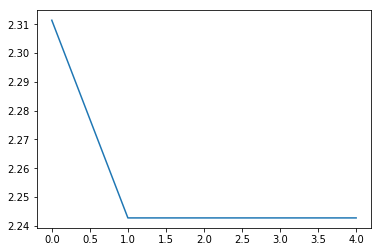

In [66]:
Xt_train1d = Xt_train[0:5000]
yt_train1d = yt_train[0:5000]

nodes_num_list = [400, 200, 10]
ac_list =               [relu(), relu(), Softmax()]
initialize_list =       [XavierInitializer(),  HeInitializer(), XavierInitializer()]
opt_list =              [NN_SGD(), AdaGrad(), AdaGrad()]

CNN = Scratch1dCNNClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=5, b_size=1, lr=0.0001)
CNN.fit(Xt_train1d, yt_train1d)
plt.plot(CNN.L)

In [61]:
CNN.FC[0].W.shape

(1, 385)

In [64]:
CNN.L

[2.2817899123131857]

In [32]:
Xt_test1d = Xt_val[0:1000]
yt_test1d = yt_val[0:1000]

#y_pred_raw = CNN.predict(Xt_test1d)
#print(y_pred_raw.shape)
"""
y_pred = np.array([])
for i in y_pred_raw:
    y_pred = np.append(y_pred, np.argmax(i))

print(y_pred.shape)
print(y_pred[0:5])
"""

'\ny_pred = np.array([])\nfor i in y_pred_raw:\n    y_pred = np.append(y_pred, np.argmax(i))\n\nprint(y_pred.shape)\nprint(y_pred[0:5])\n'

In [72]:
jisyo = {1:12, 2:30}
taple = (1,2,3,jisyo)
taple[3][1] = 20
taple

(1, 2, 3, {1: 20, 2: 30})

In [77]:
risuto = [1,2,3,4]
risuto = risuto + [5]
risuto

[1, 2, 3, 4, 5]